In [1]:
# Trading Algorithm - Level 1 Starter Kit


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Try to import technical analysis libraries
try:
    import talib
    TA_LIB_AVAILABLE = True
    print("✅ TA-Lib successfully imported")
except ImportError:
    try:
        import pandas_ta as ta
        TA_LIB_AVAILABLE = False
        print("✅ pandas_ta imported as TA-Lib alternative")
    except ImportError:
        TA_LIB_AVAILABLE = False
        print("⚠️  No TA library available - using basic indicators")

# Set up plotting style
plt.style.use('default')  # Changed from seaborn-v0_8 for compatibility
sns.set_palette("husl")

print("🚀 Trading Algorithm Environment Ready!")
print(f"📅 Current Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*50)

⚠️  No TA library available - using basic indicators
🚀 Trading Algorithm Environment Ready!
📅 Current Date: 2025-06-15 14:52:26


You are seeing this prompt because JupyterLab is using **token authentication** for security.

### How to log in:

1. **Find your token:**  
   In your terminal output, look for a URL like this:
   ```
   http://127.0.0.1:8888/?token=3166c34505e2201a576ba7aa7b76adbf6f622618317af5a9
   ```
   The part after `token=` is your token.

2. **Open JupyterLab:**  
   - Copy the full URL (including the token) and paste it into your browser.
   - Or, copy just the token value and paste it into the "Password or token" field on the login page.

3. **(Optional) Set a password:**  
   - On the login page, after entering your token, you can set a new password for future logins.

### To see running servers and tokens:
Run this command in your terminal:


In [ ]:
jupyter server list

It will show the URLs and tokens for all running Jupyter servers.

---

Let me know if you need help setting a password or have trouble logging in!

You are seeing this prompt because JupyterLab is using **token authentication** for security.

### How to log in:

1. **Find your token:**  
   In your terminal output, look for a URL like this:
   ```
   http://127.0.0.1:8888/?token=3166c34505e2201a576ba7aa7b76adbf6f622618317af5a9
   ```
   The part after `token=` is your token.

2. **Open JupyterLab:**  
   - Copy the full URL (including the token) and paste it into your browser.
   - Or, copy just the token value and paste it into the "Password or token" field on the login page.

3. **(Optional) Set a password:**  
   - On the login page, after entering your token, you can set a new password for future logins.

### To see running servers and tokens:
Run this command in your terminal:


In [ ]:
jupyter server list

It will show the URLs and tokens for all running Jupyter servers.

---

Let me know if you need help setting a password or have trouble logging in!

In [2]:
# Define our trading universe
tickers = ['SPY', 'QQQ', 'IWM', 'GLD', 'TLT', 'VIX']
period = "6mo"  # 6 months of data

# Collect data for all assets
print("📊 Downloading market data...")
data = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        data[ticker] = stock.history(period=period)
        print(f"✅ {ticker}: {len(data[ticker])} days collected")
    except Exception as e:
        print(f"❌ {ticker}: Error - {e}")

print(f"\n🎯 Data collection complete! {len(data)} assets loaded.")

📊 Downloading market data...
✅ SPY: 123 days collected
✅ QQQ: 123 days collected
✅ IWM: 123 days collected
✅ GLD: 123 days collected


$VIX: possibly delisted; no price data found  (period=6mo)


✅ TLT: 123 days collected
✅ VIX: 0 days collected

🎯 Data collection complete! 6 assets loaded.


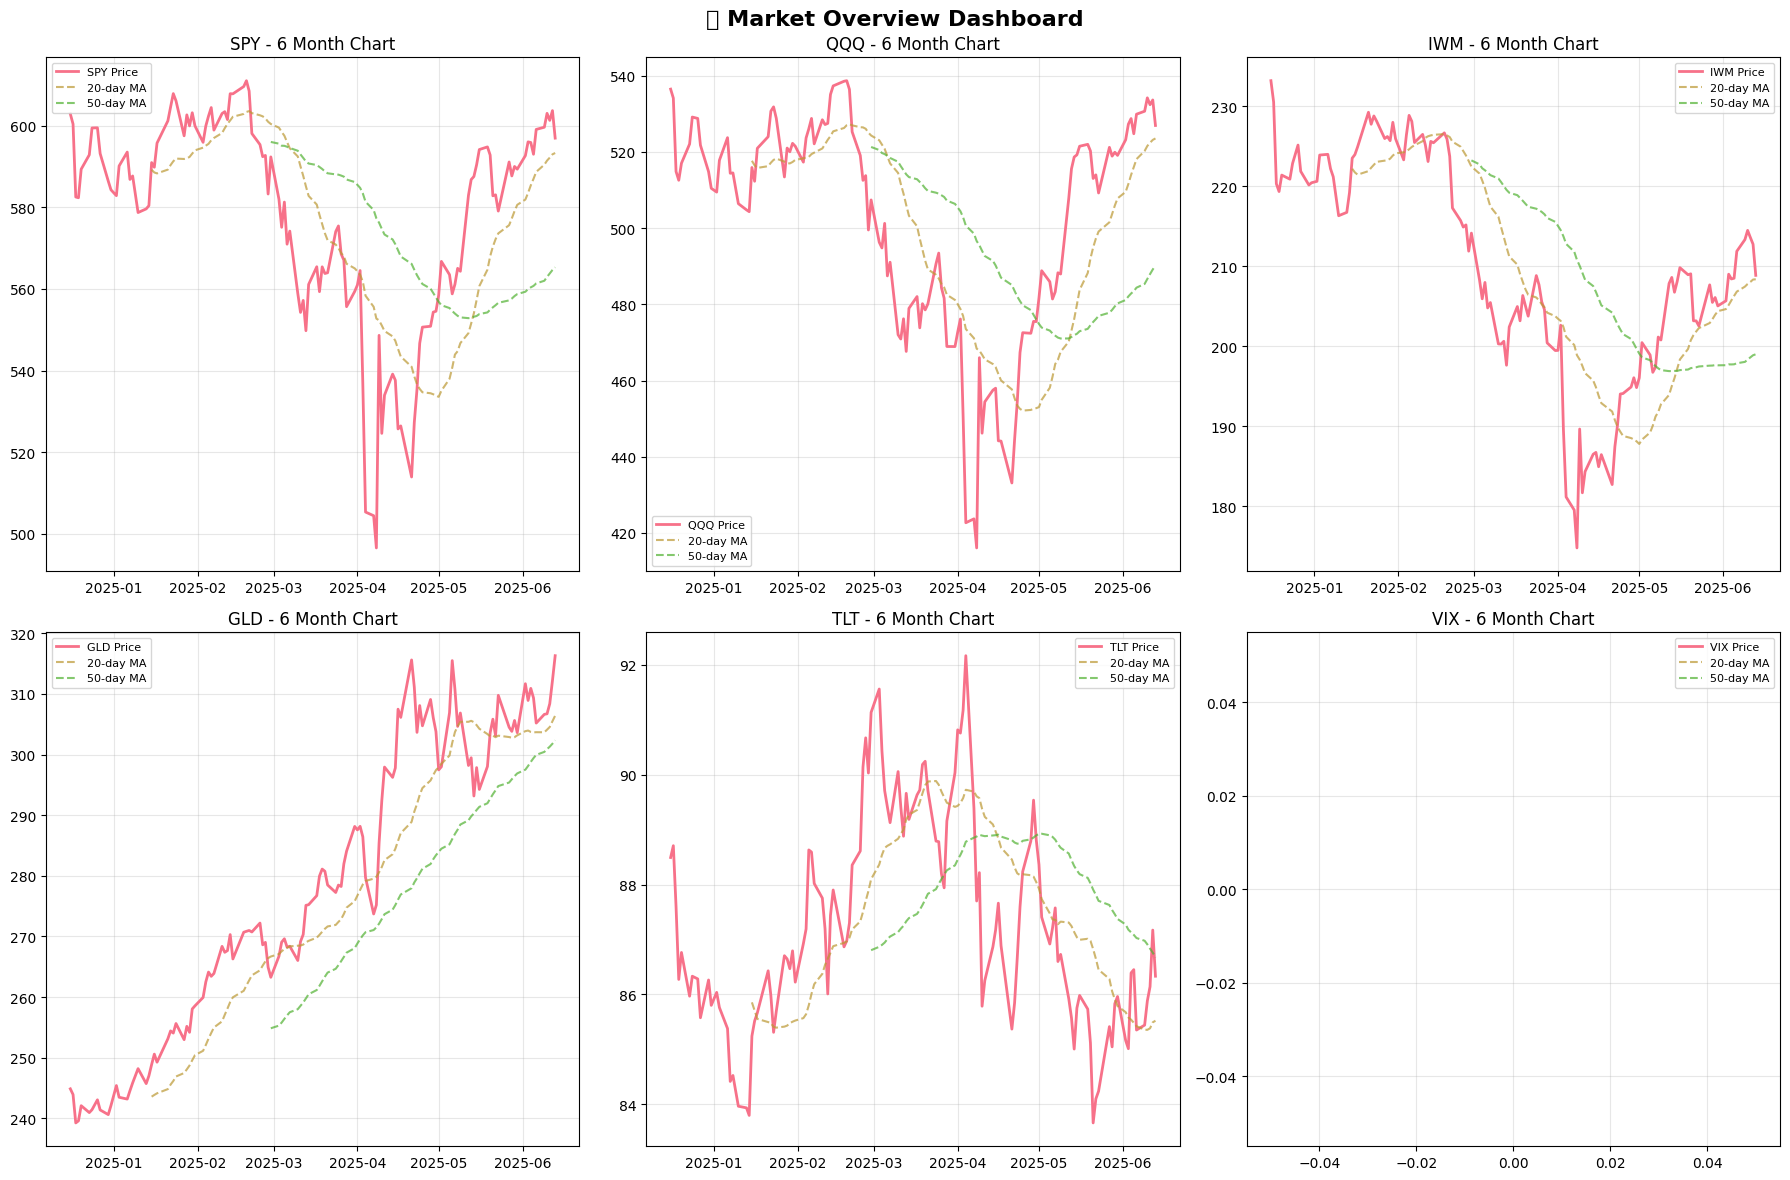


📊 6-Month Performance Summary:
SPY :   -0.99% return,  26.1% volatility
QQQ :   -1.78% return,  30.8% volatility
IWM :  -10.43% return,  26.9% volatility
GLD :  +29.16% return,  19.8% volatility
TLT :   -2.44% return,  14.2% volatility


IndexError: single positional indexer is out-of-bounds

In [3]:
# Create a comprehensive market dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📈 Market Overview Dashboard', fontsize=16, fontweight='bold')

for i, (ticker, df) in enumerate(data.items()):
    row = i // 3
    col = i % 3
    
    # Price chart with moving averages
    ax = axes[row, col]
    ax.plot(df.index, df['Close'], label=f'{ticker} Price', linewidth=2)
    ax.plot(df.index, df['Close'].rolling(20).mean(), 
            label='20-day MA', alpha=0.7, linestyle='--')
    ax.plot(df.index, df['Close'].rolling(50).mean(), 
            label='50-day MA', alpha=0.7, linestyle='--')
    
    ax.set_title(f'{ticker} - 6 Month Chart')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display performance metrics
print("\n📊 6-Month Performance Summary:")
print("="*50)
for ticker, df in data.items():
    start_price = df['Close'].iloc[0]
    end_price = df['Close'].iloc[-1]
    return_pct = ((end_price - start_price) / start_price) * 100
    volatility = df['Close'].pct_change().std() * np.sqrt(252) * 100
    
    print(f"{ticker:4s}: {return_pct:+7.2f}% return, {volatility:5.1f}% volatility")

In [ ]:
# Generate simple trading signals without TA-Lib dependency
def calculate_rsi(prices, window=14):
    """Calculate RSI manually"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD manually"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal).mean()
    macd_histogram = macd - macd_signal
    return macd, macd_signal, macd_histogram

def calculate_signals(df, short_window=20, long_window=50):
    """Calculate comprehensive trading signals"""
    signals = pd.DataFrame(index=df.index)
    signals['price'] = df['Close']
    signals['volume'] = df['Volume']
    
    # Moving averages
    signals['short_ma'] = df['Close'].rolling(window=short_window).mean()
    signals['long_ma'] = df['Close'].rolling(window=long_window).mean()
    
    # RSI
    signals['rsi'] = calculate_rsi(df['Close'])
    
    # MACD
    signals['macd'], signals['macd_signal'], signals['macd_hist'] = calculate_macd(df['Close'])
    
    # Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    signals['bb_upper'] = rolling_mean + (rolling_std * 2)
    signals['bb_lower'] = rolling_mean - (rolling_std * 2)
    
    # Generate composite signals
    signals['ma_signal'] = np.where(signals['short_ma'] > signals['long_ma'], 1, 0)
    signals['rsi_signal'] = np.where(signals['rsi'] < 30, 1, np.where(signals['rsi'] > 70, -1, 0))
    signals['macd_signal_line'] = np.where(signals['macd'] > signals['macd_signal'], 1, -1)
    
    # Composite signal (majority vote)
    signals['composite_signal'] = (
        signals['ma_signal'] + 
        np.sign(signals['rsi_signal']) + 
        (signals['macd_signal_line'] > 0).astype(int)
    ) / 3
    
    # Position changes
    signals['positions'] = signals['composite_signal'].diff()
    
    return signals

# Test on SPY with enhanced signals
spy_signals = calculate_signals(data['SPY'])

# Create comprehensive analysis plot
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# Price and moving averages
axes[0].plot(spy_signals.index, spy_signals['price'], label='SPY Price', alpha=0.7, linewidth=2)
axes[0].plot(spy_signals.index, spy_signals['short_ma'], label='20-day MA', alpha=0.8)
axes[0].plot(spy_signals.index, spy_signals['long_ma'], label='50-day MA', alpha=0.8)
axes[0].plot(spy_signals.index, spy_signals['bb_upper'], label='BB Upper', linestyle='--', alpha=0.6)
axes[0].plot(spy_signals.index, spy_signals['bb_lower'], label='BB Lower', linestyle='--', alpha=0.6)

# Mark signals
buy_signals = spy_signals[spy_signals['positions'] > 0.3]
sell_signals = spy_signals[spy_signals['positions'] < -0.3]

axes[0].scatter(buy_signals.index, buy_signals['price'], 
               color='green', marker='^', s=100, label='Buy Signal', zorder=5)
axes[0].scatter(sell_signals.index, sell_signals['price'], 
               color='red', marker='v', s=100, label='Sell Signal', zorder=5)

axes[0].set_title('SPY Price with Trading Signals')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(spy_signals.index, spy_signals['rsi'], label='RSI', color='orange')
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
axes[1].set_title('RSI (Relative Strength Index)')
axes[1].set_ylabel('RSI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MACD
axes[2].plot(spy_signals.index, spy_signals['macd'], label='MACD', color='blue')
axes[2].plot(spy_signals.index, spy_signals['macd_signal'], label='Signal Line', color='red')
axes[2].bar(spy_signals.index, spy_signals['macd_hist'], label='Histogram', alpha=0.6)
axes[2].set_title('MACD')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Composite signal
axes[3].plot(spy_signals.index, spy_signals['composite_signal'], label='Composite Signal', linewidth=2)
axes[3].axhline(y=0.3, color='g', linestyle='--', alpha=0.7, label='Buy Threshold')
axes[3].axhline(y=-0.3, color='r', linestyle='--', alpha=0.7, label='Sell Threshold')
axes[3].set_title('Composite Trading Signal')
axes[3].set_ylabel('Signal Strength')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Enhanced Analysis Complete:")
print(f"   • {len(buy_signals)} strong buy signals")
print(f"   • {len(sell_signals)} strong sell signals")
print(f"   • Current RSI: {spy_signals['rsi'].iloc[-1]:.1f}")
print(f"   • Current Signal Strength: {spy_signals['composite_signal'].iloc[-1]:.2f}")

In [ ]:
# Create a simple portfolio tracker
class PaperTradingPortfolio:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.positions = {}
        self.trades = []
        self.equity_curve = []
    
    def buy(self, ticker, price, quantity, date):
        cost = price * quantity
        if cost <= self.capital:
            self.capital -= cost
            self.positions[ticker] = self.positions.get(ticker, 0) + quantity
            self.trades.append({
                'date': date, 'action': 'BUY', 'ticker': ticker, 
                'price': price, 'quantity': quantity, 'value': cost
            })
            print(f"✅ BUY: {quantity} {ticker} @ ${price:.2f} (${cost:.2f})")
        else:
            print(f"❌ Insufficient capital for {ticker}")
    
    def sell(self, ticker, price, quantity, date):
        if self.positions.get(ticker, 0) >= quantity:
            revenue = price * quantity
            self.capital += revenue
            self.positions[ticker] -= quantity
            self.trades.append({
                'date': date, 'action': 'SELL', 'ticker': ticker, 
                'price': price, 'quantity': quantity, 'value': revenue
            })
            print(f"💰 SELL: {quantity} {ticker} @ ${price:.2f} (${revenue:.2f})")
        else:
            print(f"❌ Insufficient {ticker} shares to sell")
    
    def get_portfolio_value(self, current_prices):
        stock_value = sum(qty * current_prices.get(ticker, 0) 
                         for ticker, qty in self.positions.items())
        return self.capital + stock_value
    
    def get_performance_summary(self):
        return {
            'trades': len(self.trades),
            'current_capital': self.capital,
            'positions': self.positions,
            'total_trades_value': sum(abs(trade['value']) for trade in self.trades)
        }

# Initialize paper trading portfolio
portfolio = PaperTradingPortfolio()

# Simulate a few trades based on our signals
current_spy_price = data['SPY']['Close'].iloc[-1]
portfolio.buy('SPY', current_spy_price, 10, datetime.now())

print(f"\n💼 Portfolio Summary:")
print(f"Cash: ${portfolio.capital:.2f}")
print(f"Positions: {portfolio.positions}")
print(f"Portfolio Value: ${portfolio.get_portfolio_value({'SPY': current_spy_price}):.2f}")